In [ ]:
import os
import tarfile
import zipfile
import numpy as np
from pydub import AudioSegment
from scipy.io.wavfile import write
from scipy.signal import butter, lfilter, convolve
import librosa
import random
import torch
import torchaudio
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, f1_score, auc
import matplotlib.pyplot as plt
from transformers import HubertModel, AutoProcessor
from tqdm import tqdm
import pickle
import torchvision.models as models

# ASV (Artifacts)

In [12]:
protocol_file = "ASV/Labels.txt" 

label_dict = {}
with open(protocol_file, "r") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) < 5:
            continue
        _, filename, _, _, label = parts
        label_dict[filename] = 1 if label == "bonafide" else 0
print(f"Label dictionary created with {len(label_dict)} labels.")

Label dictionary created with 71237 labels.


In [17]:
audio_folder = "ASV/Data"
artifacts_folder = "ASV/Artifact"

original_files = [os.path.join(audio_folder, f) for f in os.listdir(audio_folder) if f.endswith(".flac")]
artifacts_files = [os.path.join(artifacts_folder, f) for f in os.listdir(artifacts_folder) if f.endswith(".wav")]

files = original_files + artifacts_files
ASV_labels = []

ASV_files = []

for file in files:
    filename = os.path.basename(file)
    name_without_ext = os.path.splitext(filename)[0]
    
    if filename.endswith(".flac"):
        base_name = name_without_ext
    else:
        base_name = "_".join(name_without_ext.split("_")[:-1])
    
    label = label_dict.get(base_name, None)
    
    if label is not None:
        ASV_files.append(file)
        ASV_labels.append(label)

print(f"Total files: {len(ASV_files)}, Total labels: {len(ASV_labels)}")


Total files: 142474, Total labels: 142474


# FoR (Artifacts)

In [21]:
filenames = ["training", "validation", "testing"]
FoR_files = {}
FoR_labels = {}

for i in filenames:

    real_audio_folder = f"FoR/{i}/real"
    fake_audio_folder = f"FoR/{i}/fake"

    real_artifacts_folder = f"FoR/{i}/real_artifacts"
    fake_artifacts_folder = f"FoR/{i}/fake_artifacts"

    os.makedirs(real_artifacts_folder, exist_ok=True)
    os.makedirs(fake_artifacts_folder, exist_ok=True)

    real_original_files = [os.path.join(real_audio_folder, f) for f in os.listdir(real_audio_folder) if f.endswith(".wav")]
    fake_original_files = [os.path.join(fake_audio_folder, f) for f in os.listdir(fake_audio_folder) if f.endswith(".wav")]

    real_artifacts_files = [os.path.join(real_artifacts_folder, f) for f in os.listdir(real_artifacts_folder) if f.endswith(".wav")]
    fake_artifacts_files = [os.path.join(fake_artifacts_folder, f) for f in os.listdir(fake_artifacts_folder) if f.endswith(".wav")]

    real_files = real_original_files + real_artifacts_files
    fake_files = fake_original_files + fake_artifacts_files

    FoR_files[i] = real_files + fake_files

    real_label = [1] * len(real_files)
    fake_label = [0] * len(fake_files)

    FoR_labels[i] = np.array(real_label + fake_label, dtype=np.int8)

    print(f"Total files: {len(FoR_files[i])}, Total labels: {len(FoR_labels[i])} for {i} dataset")

Total files: 107736, Total labels: 107736 for training dataset
Total files: 21596, Total labels: 21596 for validation dataset
Total files: 9268, Total labels: 9268 for testing dataset


# Hubert

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
model = HubertModel.from_pretrained("facebook/hubert-large-ls960-ft", output_hidden_states=True).to(device)
model.eval()
print(device)

cuda


In [23]:
BATCH_SIZE = 64
def process_batch(filenames):
    waveforms = []
    successful_files = []
    for filename in filenames:
        try:
            waveform, sample_rate = torchaudio.load(filename)
            waveform = waveform.to(device)
            if sample_rate != 16000:
                waveform = torchaudio.transforms.Resample(sample_rate, 16000)(waveform)
            if waveform.size(0) > 1:
                waveform = waveform.mean(dim=0, keepdim=True)
            waveforms.append(waveform.squeeze(0))
            successful_files.append(filename)

    
        except RuntimeError as e:
                print(f"Error loading {filename}: {e}")
                continue

    batch_features = []
    with torch.no_grad():
        for waveform in waveforms:
            inputs = processor(waveform, sampling_rate=16000, return_tensors="pt").to(device)
            outputs = model(**inputs)
            hidden_states = outputs.hidden_states[2:6]  # layers 3rd to 6th
            pooled = [hs.mean(dim=1).squeeze(0).cpu().numpy() for hs in hidden_states]
            batch_features.append(np.stack(pooled, axis=0))

    return batch_features, successful_files

def get_pkl(files, labels, output_file):
    features, filtered_labels = [], []
    
    for i in tqdm(range(0, len(files), BATCH_SIZE), desc="Extracting features"):
        batch_files = files[i:i + BATCH_SIZE]
        batch_labels = labels[i:i + BATCH_SIZE]
        
        batch_features, successful_files = process_batch(batch_files)
        
        successful_indices = [batch_files.index(file) for file in successful_files]
        filtered_batch_labels = [batch_labels[idx] for idx in successful_indices]
        
        features.extend(batch_features)
        filtered_labels.extend(filtered_batch_labels)

    features = np.array(features, dtype=np.float32)
    filtered_labels = np.array(filtered_labels, dtype=np.int8)

    with open(output_file, "wb") as f:
        pickle.dump({"features": features, "labels": filtered_labels}, f)

    print(f"Saved extracted features to {output_file}")
    print(f"Features: {len(features)}, Labels: {len(filtered_labels)}")

In [ ]:
def get_pkl(files, labels, output_file):
    features, filtered_labels = [], []
    
    for i in tqdm(range(0, len(files), BATCH_SIZE), desc="Extracting features"):
        batch_files = files[i:i + BATCH_SIZE]
        batch_labels = labels[i:i + BATCH_SIZE]
        
        batch_features, successful_files = process_batch(batch_files)
        
        successful_indices = [batch_files.index(file) for file in successful_files]
        filtered_batch_labels = [batch_labels[idx] for idx in successful_indices]
        
        features.extend(batch_features)
        filtered_labels.extend(filtered_batch_labels)

    features = np.array(features, dtype=np.float32)
    filtered_labels = np.array(filtered_labels, dtype=np.int8)

    with open(output_file, "wb") as f:
        pickle.dump({"features": features, "labels": filtered_labels}, f)

    print(f"Saved extracted features to {output_file}")
    print(f"Features: {len(features)}, Labels: {len(filtered_labels)}")

In [24]:
get_pkl(ASV_files, ASV_labels, "ASV_Opt_Dataset.pkl")

Extracting features: 100%|██████████| 2227/2227 [44:25<00:00,  1.20s/it]


Saved extracted features to ASV_Opt_Dataset.pkl
Features: 142474, Labels: 142474


In [25]:
get_pkl(FoR_files["training"], FoR_labels["training"], "FoR_Opt_Train.pkl")
get_pkl(FoR_files["validation"], FoR_labels["validation"], "FoR_Opt_Validation.pkl")
get_pkl(FoR_files["testing"], FoR_labels["testing"], "FoR_Opt_Testing.pkl")

Extracting features:   5%|▌         | 85/1684 [02:27<45:02,  1.69s/it]

Error loading FoR/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav: Failed to decode audio.


Extracting features:  18%|█▊        | 306/1684 [08:41<39:40,  1.73s/it]

Error loading FoR/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav: Failed to decode audio.


Extracting features:  46%|████▌     | 778/1684 [21:39<24:40,  1.63s/it]

Error loading FoR/training/real_artifacts/file11064.wav_16k.wav_norm.wav_mono.wav_silence_clipping.wav: Failed to decode audio.


Extracting features:  48%|████▊     | 815/1684 [22:40<23:26,  1.62s/it]

Error loading FoR/training/real_artifacts/file15440.wav_16k.wav_norm.wav_mono.wav_silence_filter.wav: Failed to decode audio.


Extracting features: 100%|██████████| 1684/1684 [36:13<00:00,  1.29s/it]


Saved extracted features to FoR_Opt_Train.pkl
Features: 107732, Labels: 107732


Extracting features: 100%|██████████| 338/338 [07:18<00:00,  1.30s/it]


Saved extracted features to FoR_Opt_Validation.pkl
Features: 21596, Labels: 21596


Extracting features: 100%|██████████| 145/145 [02:26<00:00,  1.01s/it]

Saved extracted features to FoR_Opt_Testing.pkl
Features: 9268, Labels: 9268


# Model (ResNet)

In [26]:
class LayerFeatureDataset(Dataset):
    def __init__(self, pkl_path):
        data = pickle.load(open(pkl_path, 'rb'))
        self.X = torch.tensor(data['features'], dtype=torch.float32)  
        self.y = torch.tensor(data['labels'],   dtype=torch.long)    
    def __len__(self):
        return len(self.y)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

class LayerWeightedAggregator(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        self.w = nn.Parameter(torch.ones(num_layers) / num_layers)
    def forward(self, x):
        w = torch.softmax(self.w, dim=0)             
        return (x * w[None, :, None]).sum(dim=1)

class ResNetClassifier(nn.Module):
    def __init__(self, num_layers, hidden_dim, num_classes):
        super().__init__()
        self.agg = LayerWeightedAggregator(num_layers)
        H = W = int(np.sqrt(hidden_dim))
        assert H*W == hidden_dim, "hidden_dim must be square"
        self.H, self.W = H, W

        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1,
            self.resnet.conv1.out_channels,
            kernel_size=self.resnet.conv1.kernel_size,
            stride=self.resnet.conv1.stride,
            padding=self.resnet.conv1.padding,
            bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.agg(x)               
        b = x.size(0)
        x = x.view(b, 1, self.H, self.W)
        return self.resnet(x)


In [54]:
def Train(model, optimizer, criterion, train_loader, val_loader, num_epochs=50):
    eer_per_epoch = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)

        model.eval()
        all_labels = []
        all_probs = []
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                probs = torch.softmax(outputs, dim=1)[:, 1]
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)

        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        fnr = 1 - tpr
        eer = fpr[np.nanargmin(np.abs(fpr - fnr))]
        eer_per_epoch.append(eer)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val EER: {eer:.4f}")
        
    return eer_per_epoch

In [55]:
def Test(model, test_loader, name="Model"):
    model.eval()
    all_labels = []
    all_preds  = []
    all_probs  = []

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)

            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds  = np.array(all_preds)
    all_probs  = np.array(all_probs)

    accuracy  = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall    = recall_score(all_labels, all_preds)
    f1        = f1_score(all_labels, all_preds)

    TP = np.sum((all_preds == 1) & (all_labels == 1))
    TN = np.sum((all_preds == 0) & (all_labels == 0))
    FP = np.sum((all_preds == 1) & (all_labels == 0))
    FN = np.sum((all_preds == 0) & (all_labels == 1))

    fpr_manual = FP / (FP + TN) if (FP + TN) > 0 else 0.0
    fnr_manual = FN / (FN + TP) if (FN + TP) > 0 else 0.0

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fpr - fnr))
    eer = fpr[eer_index]
    roc_auc = auc(fpr, tpr)

    print(f"\n === Evaluation Metrics: {name} ===")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"FPR      : {fpr_manual:.4f}")
    print(f"FNR      : {fnr_manual:.4f}")
    print(f"EER      : {eer:.4f}")
    print(f"AUC      : {roc_auc:.4f}")

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.4f})')
    plt.plot([0,1], [0,1], '--', label='Random')
    plt.scatter(fpr[eer_index], tpr[eer_index], color='red',
                label=f'EER = {eer:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

In [29]:
pkl_path = "Features/Opt_Features/ASV_Opt_Dataset.pkl"
dataset = LayerFeatureDataset(pkl_path)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

ASV_train_dataset, ASV_val_dataset, ASV_test_dataset = random_split(dataset, [train_size, val_size, test_size])

num_layers  = dataset.X.size(1)
hidden_dim  = dataset.X.size(2)
num_classes = len(torch.unique(dataset.y))

criterion = nn.CrossEntropyLoss()

In [ ]:
Train_loader = DataLoader(ASV_train_dataset, batch_size=64, shuffle=True)
Val_loader = DataLoader(ASV_val_dataset, batch_size=64, shuffle=False)  
Test_loader = DataLoader(ASV_test_dataset, batch_size=64, shuffle=False)
print(f"Training samples: {train_size}, Validation samples: {val_size}, Testing samples: {test_size}")

Training samples: 113979, Validation samples: 14247, Testing samples: 14248


Epoch 1/50, Loss: 0.0782, Val EER: 0.0200
Epoch 2/50, Loss: 0.0301, Val EER: 0.0138
Epoch 3/50, Loss: 0.0232, Val EER: 0.0119
Epoch 4/50, Loss: 0.0173, Val EER: 0.0116
Epoch 5/50, Loss: 0.0163, Val EER: 0.0088
Epoch 6/50, Loss: 0.0131, Val EER: 0.0071
Epoch 7/50, Loss: 0.0118, Val EER: 0.0081
Epoch 8/50, Loss: 0.0111, Val EER: 0.0061
Epoch 9/50, Loss: 0.0096, Val EER: 0.0052
Epoch 10/50, Loss: 0.0086, Val EER: 0.0048
Epoch 11/50, Loss: 0.0088, Val EER: 0.0069
Epoch 12/50, Loss: 0.0091, Val EER: 0.0046
Epoch 13/50, Loss: 0.0070, Val EER: 0.0047
Epoch 14/50, Loss: 0.0060, Val EER: 0.0044
Epoch 15/50, Loss: 0.0071, Val EER: 0.0181
Epoch 16/50, Loss: 0.0075, Val EER: 0.0042
Epoch 17/50, Loss: 0.0054, Val EER: 0.0051
Epoch 18/50, Loss: 0.0047, Val EER: 0.0036
Epoch 19/50, Loss: 0.0052, Val EER: 0.0049
Epoch 20/50, Loss: 0.0050, Val EER: 0.0036
Epoch 21/50, Loss: 0.0039, Val EER: 0.0030
Epoch 22/50, Loss: 0.0045, Val EER: 0.0036
Epoch 23/50, Loss: 0.0039, Val EER: 0.0033
Epoch 24/50, Loss: 0

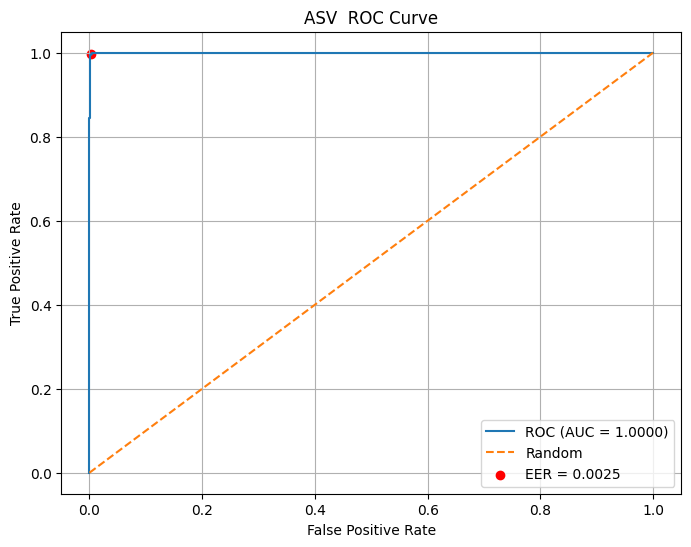

In [ ]:
model = ResNetClassifier(num_layers, hidden_dim, num_classes).to(device)
optimizer_base = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

eer_asv = Train(model, optimizer_base, criterion, Train_loader, Val_loader)
Test(model, Test_loader, "ASV")

In [74]:
pkl_path = "Features/Opt_Features/FoR_Opt_Train.pkl"
dataset1 = LayerFeatureDataset(pkl_path)

pkl_path = "Features/Opt_Features/FoR_Opt_Validation.pkl"
dataset2 = LayerFeatureDataset(pkl_path)

pkl_path = "Features/Opt_Features/FoR_Opt_Testing.pkl"
dataset3 = LayerFeatureDataset(pkl_path)

dataset = dataset1 + dataset2 + dataset3    
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

FoR_train_dataset, FoR_val_dataset, FoR_test_dataset = random_split(dataset, [train_size, val_size, test_size])                                               

Train_loader = DataLoader(FoR_train_dataset, batch_size=64, shuffle=True)
Val_loader = DataLoader(FoR_test_dataset, batch_size=64, shuffle=False)
Test_loader = DataLoader(FoR_val_dataset, batch_size=64, shuffle=False)
print(f"Training samples: {len(FoR_train_dataset)}, Validation samples: {len(FoR_val_dataset)}, Testing samples: {len(FoR_test_dataset)}")

Training samples: 110876, Validation samples: 13859, Testing samples: 13861


Epoch 1/50, Loss: 0.0804, Val EER: 0.0189
Epoch 2/50, Loss: 0.0374, Val EER: 0.0095
Epoch 3/50, Loss: 0.0306, Val EER: 0.0119
Epoch 4/50, Loss: 0.0255, Val EER: 0.0120
Epoch 5/50, Loss: 0.0215, Val EER: 0.0089
Epoch 6/50, Loss: 0.0195, Val EER: 0.0077
Epoch 7/50, Loss: 0.0173, Val EER: 0.0077
Epoch 8/50, Loss: 0.0165, Val EER: 0.0085
Epoch 9/50, Loss: 0.0145, Val EER: 0.0082
Epoch 10/50, Loss: 0.0140, Val EER: 0.0076
Epoch 11/50, Loss: 0.0125, Val EER: 0.0090
Epoch 12/50, Loss: 0.0124, Val EER: 0.0067
Epoch 13/50, Loss: 0.0110, Val EER: 0.0064
Epoch 14/50, Loss: 0.0112, Val EER: 0.0080
Epoch 15/50, Loss: 0.0102, Val EER: 0.0052
Epoch 16/50, Loss: 0.0097, Val EER: 0.0057
Epoch 17/50, Loss: 0.0090, Val EER: 0.0057
Epoch 18/50, Loss: 0.0088, Val EER: 0.0059
Epoch 19/50, Loss: 0.0086, Val EER: 0.0053
Epoch 20/50, Loss: 0.0076, Val EER: 0.0089
Epoch 21/50, Loss: 0.0081, Val EER: 0.0054
Epoch 22/50, Loss: 0.0082, Val EER: 0.0044
Epoch 23/50, Loss: 0.0072, Val EER: 0.0057
Epoch 24/50, Loss: 0

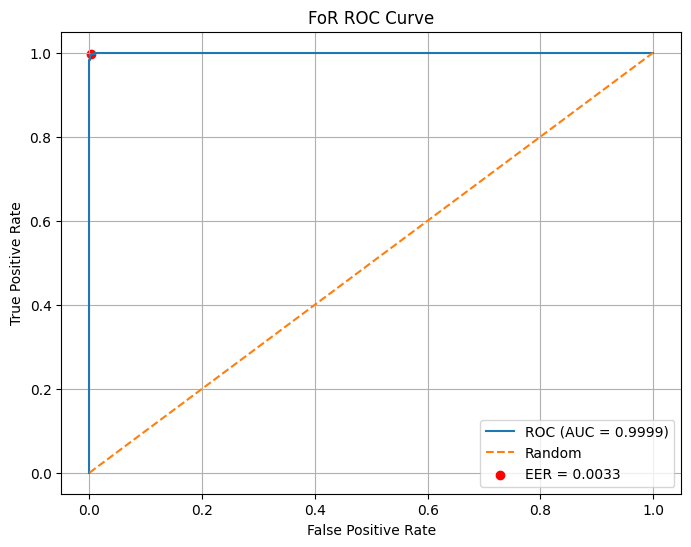

In [76]:
model = ResNetClassifier(num_layers, hidden_dim, num_classes).to(device)
optimizer_base = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

eer_for = Train(model, optimizer_base, criterion, Train_loader, Val_loader)
Test(model, Test_loader, "FoR")

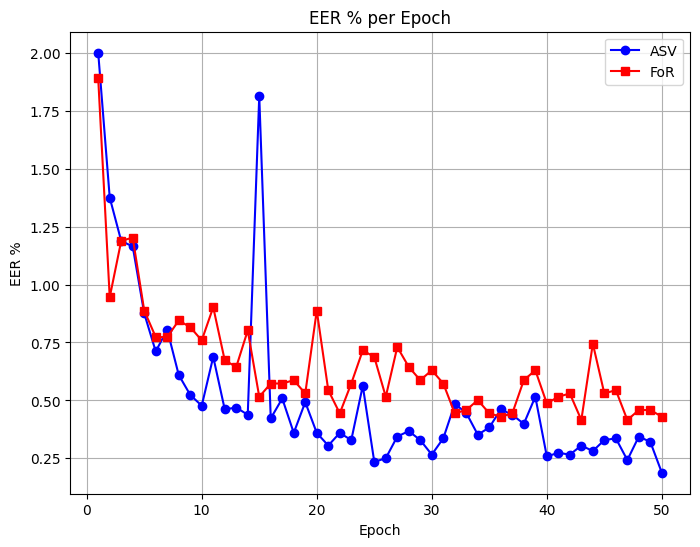

In [78]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 51), [100*eer for eer in eer_asv], marker='o', label="ASV", color='b')
plt.plot(range(1, 51), [100*eer for eer in eer_for], marker='s', label="FoR", color='r')
plt.xlabel("Epoch")
plt.ylabel("EER %")
plt.title("EER % per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [79]:
Combined_train_dataset = torch.utils.data.ConcatDataset([ASV_train_dataset, FoR_train_dataset])
Combined_val_dataset = torch.utils.data.ConcatDataset([ASV_val_dataset, FoR_val_dataset])
Combined_test_dataset = torch.utils.data.ConcatDataset([ASV_test_dataset, FoR_test_dataset])

train_loader = DataLoader(Combined_train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(Combined_val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(Combined_test_dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(Combined_train_dataset)}, Validation samples: {len(Combined_val_dataset)}, Testing samples: {len(Combined_test_dataset)}")

Training samples: 224855, Validation samples: 28106, Testing samples: 28109


Epoch 1/50, Loss: 0.0898, Val EER: 0.0214
Epoch 2/50, Loss: 0.0418, Val EER: 0.0149
Epoch 3/50, Loss: 0.0325, Val EER: 0.0127
Epoch 4/50, Loss: 0.0265, Val EER: 0.0129
Epoch 5/50, Loss: 0.0232, Val EER: 0.0133
Epoch 6/50, Loss: 0.0200, Val EER: 0.0102
Epoch 7/50, Loss: 0.0174, Val EER: 0.0107
Epoch 8/50, Loss: 0.0157, Val EER: 0.0080
Epoch 9/50, Loss: 0.0146, Val EER: 0.0107
Epoch 10/50, Loss: 0.0136, Val EER: 0.0076
Epoch 11/50, Loss: 0.0123, Val EER: 0.0072
Epoch 12/50, Loss: 0.0118, Val EER: 0.0059
Epoch 13/50, Loss: 0.0110, Val EER: 0.0061
Epoch 14/50, Loss: 0.0101, Val EER: 0.0069
Epoch 15/50, Loss: 0.0099, Val EER: 0.0063
Epoch 16/50, Loss: 0.0092, Val EER: 0.0063
Epoch 17/50, Loss: 0.0087, Val EER: 0.0077
Epoch 18/50, Loss: 0.0082, Val EER: 0.0052
Epoch 19/50, Loss: 0.0082, Val EER: 0.0046
Epoch 20/50, Loss: 0.0073, Val EER: 0.0066
Epoch 21/50, Loss: 0.0075, Val EER: 0.0067
Epoch 22/50, Loss: 0.0072, Val EER: 0.0059
Epoch 23/50, Loss: 0.0066, Val EER: 0.0046
Epoch 24/50, Loss: 0

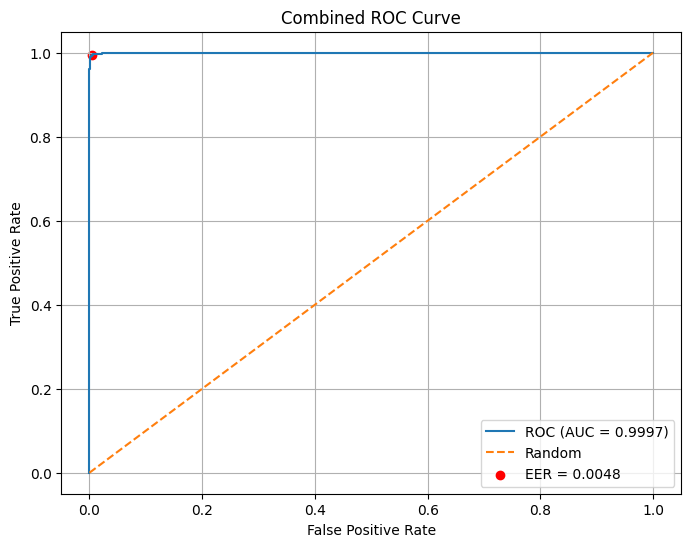

In [81]:
model = ResNetClassifier(num_layers, hidden_dim, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

eer_combined = Train(model, optimizer, criterion, train_loader, val_loader)
Test(model, test_loader, "Combined")